# LIBRARIES

In [51]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
## Import solve_ivp
from scipy.integrate import solve_ivp
import yaml
import time
import os

## Import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from neuralsens import partial_derivatives as ns
from neuralsens.partial_derivatives import calculate_second_partial_derivatives_mlp,calculate_first_partial_derivatives_mlp
## Import train test split
from sklearn.model_selection import train_test_split
## Import Voronoi
from scipy.spatial import Voronoi
import sys
## Windows Version
if sys.platform == 'win32':
    sys.path.insert(0, 'C:/Users/apolo/OneDrive - Universidad Pontificia Comillas/Escritorio/PhD/Codigo/LipschitzNN/Scripts/')
    sys.path.insert(0, 'C:/Users/apolo/OneDrive - Universidad Pontificia Comillas/Escritorio/IIT/NN Monotonic/Scripts/')
    sys.path.insert(0, 'C:/Users/apolo/OneDrive - Universidad Pontificia Comillas/Escritorio/IIT/Innomerics/Scientific_ML/')
## Mac Version
if sys.platform == 'darwin':
    sys.path.insert(0,'/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/PhD/Codigo/LipschitzNN/Scripts/')
    sys.path.insert(0,'/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/PhD/Codigo/LipschitzNN/')
    sys.path.insert(0,'/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/IIT/NN Monotonic/Scripts/')
    

import Scripts
import DNN
import train
import data_load_lipschitz
import Utils

import Utilities as Utilities
import utilities_voronoi
import utilities_lipschitz
import importlib

from utilities_voronoi import *
importlib.reload(utilities_voronoi)
importlib.reload(Utilities)
importlib.reload(DNN)
importlib.reload(train)
importlib.reload(data_load_lipschitz)
importlib.reload(Utils)

from data_load_lipschitz import data_load_lipschitz
from data_load_lipschitz import generate_data_Neumann
from train import train
from DNN import DNN

# DATA LOAD

## AUTOMPG

In [4]:
import pandas as pd
df_data = pd.read_fwf("../Data/Auto_MPG/auto+mpg/auto-mpg.data")
df_data.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
## Drop last column
df_data = df_data.drop(columns = ['car name'])
## Drop nan
df_data = df_data.dropna()
## Conver variable origin and cylinders to categorical
df_data['origin'] = df_data['origin'].astype('category')
## Convert variable horsequerpower to numeric
df_data['horsepower'] = pd.to_numeric(df_data['horsepower'], errors='coerce')
df_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,15.0,8,350.0,165.0,3693.0,11.5,70,1
1,18.0,8,318.0,150.0,3436.0,11.0,70,1
2,16.0,8,304.0,150.0,3433.0,12.0,70,1
3,17.0,8,302.0,140.0,3449.0,10.5,70,1
4,15.0,8,429.0,198.0,4341.0,10.0,70,1


In [5]:
df_data.dtypes

mpg              float64
cylinders          int64
displacement     float64
horsepower       float64
weight           float64
acceleration     float64
model year         int64
origin          category
dtype: object

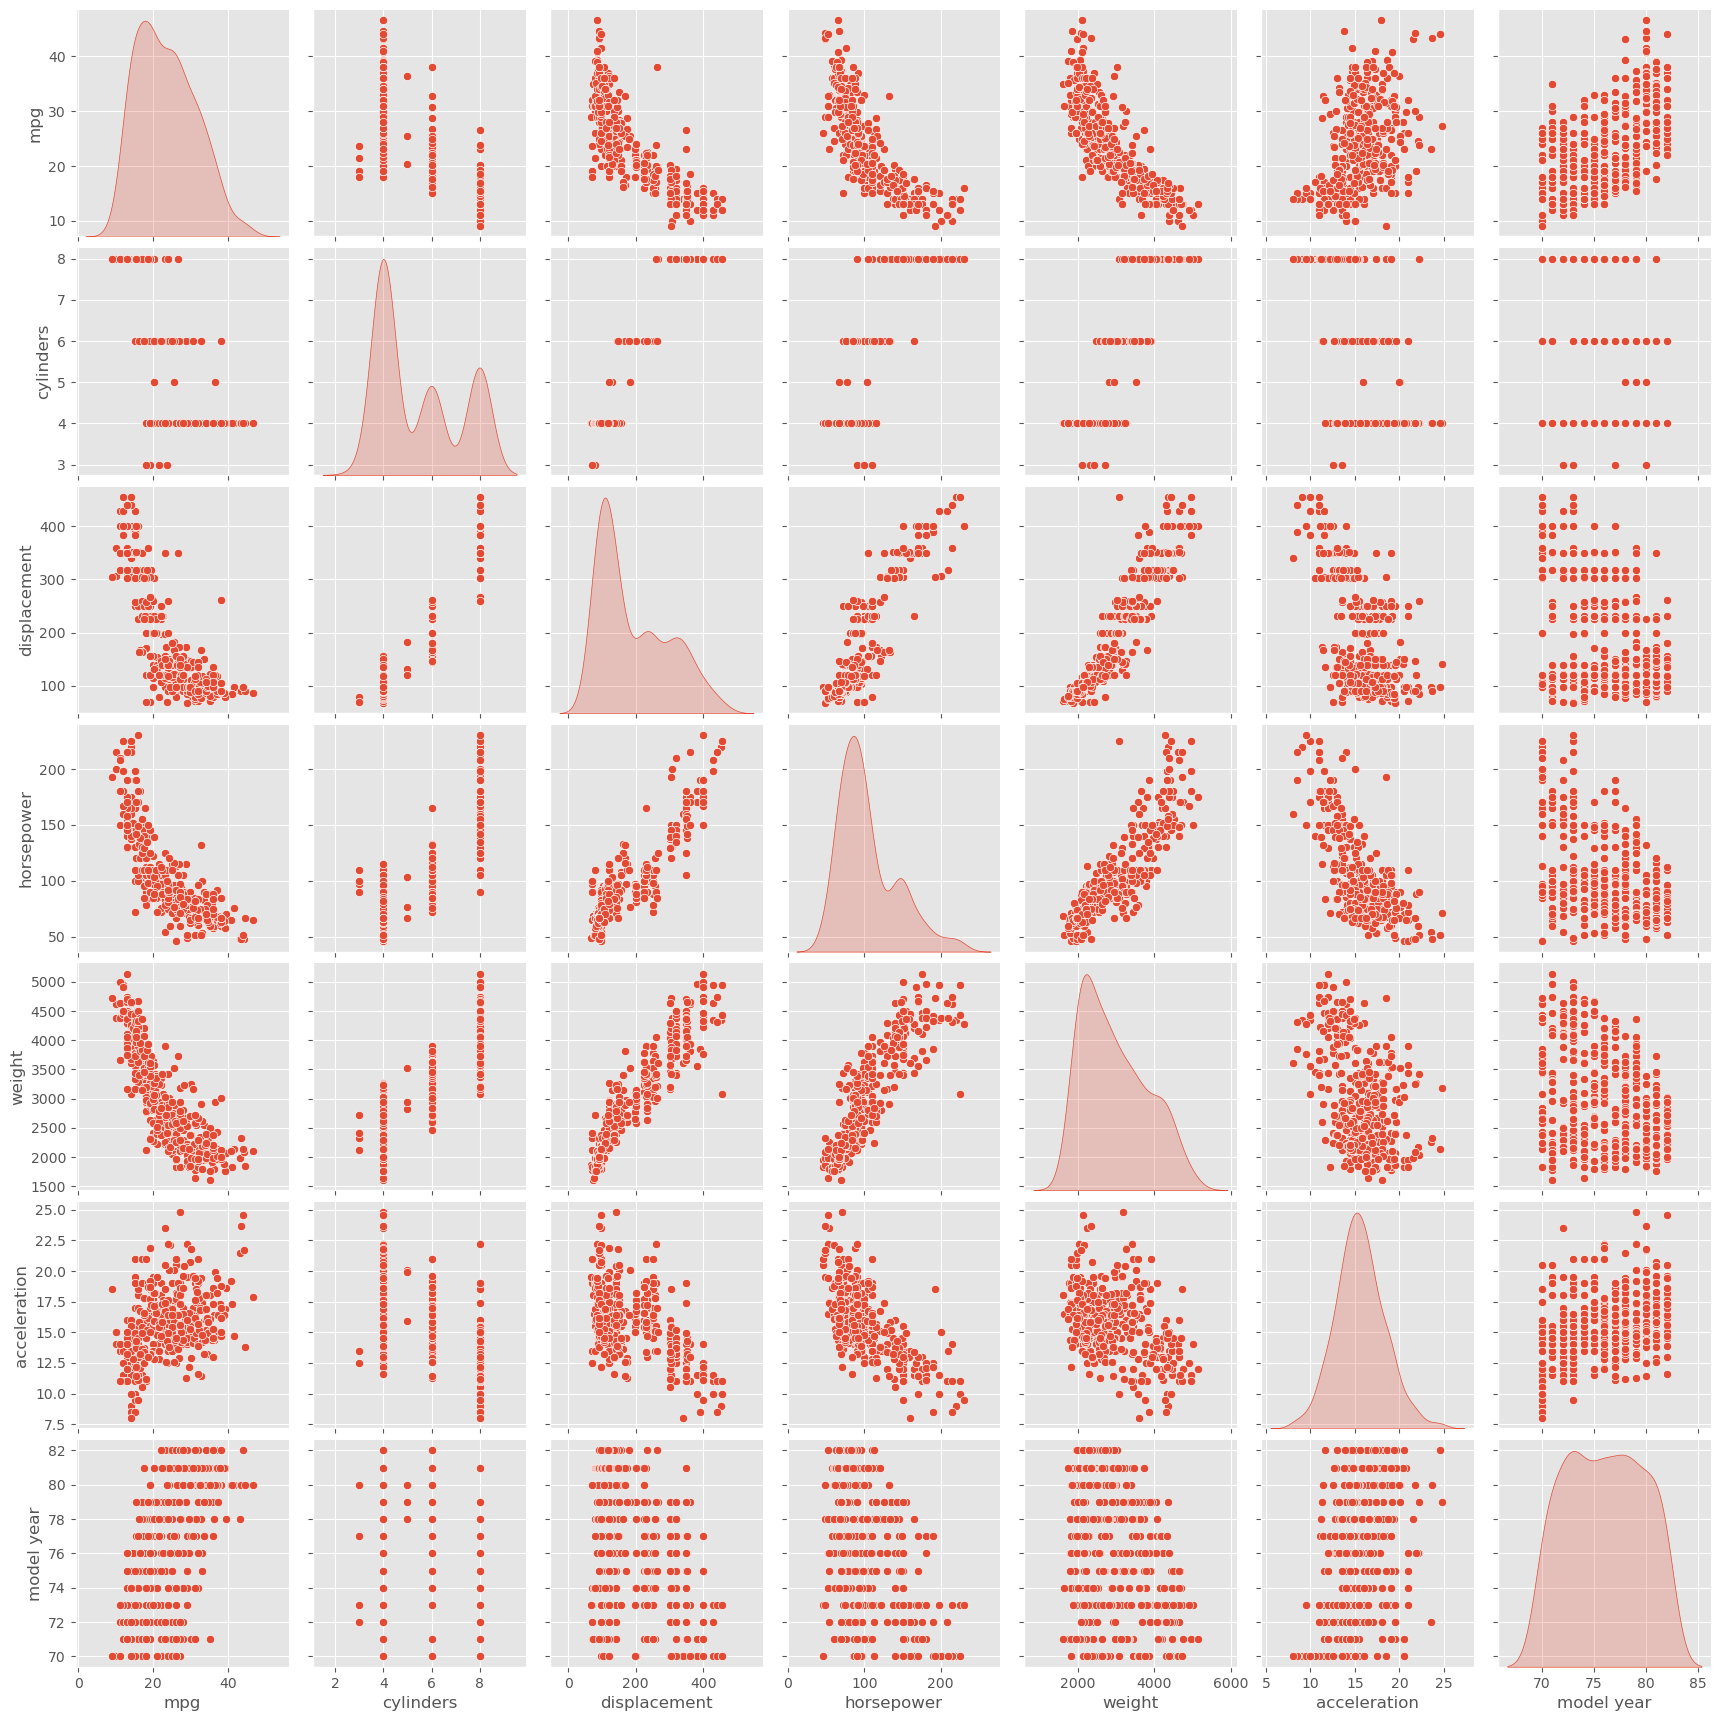

In [6]:
## Represent pairplot
## Dont show future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.pairplot(df_data, diag_kind="kde")

## ESL

In [74]:
##### LOAD DATA

raw_data = loadarff('../Data/ESL/ESL.arff')
df_data = pd.DataFrame(raw_data[0])
print(len(df_data))
## Drop duplicates of df_data -> Number of unique rows
len(df_data.iloc[:,:4].drop_duplicates())

488


199

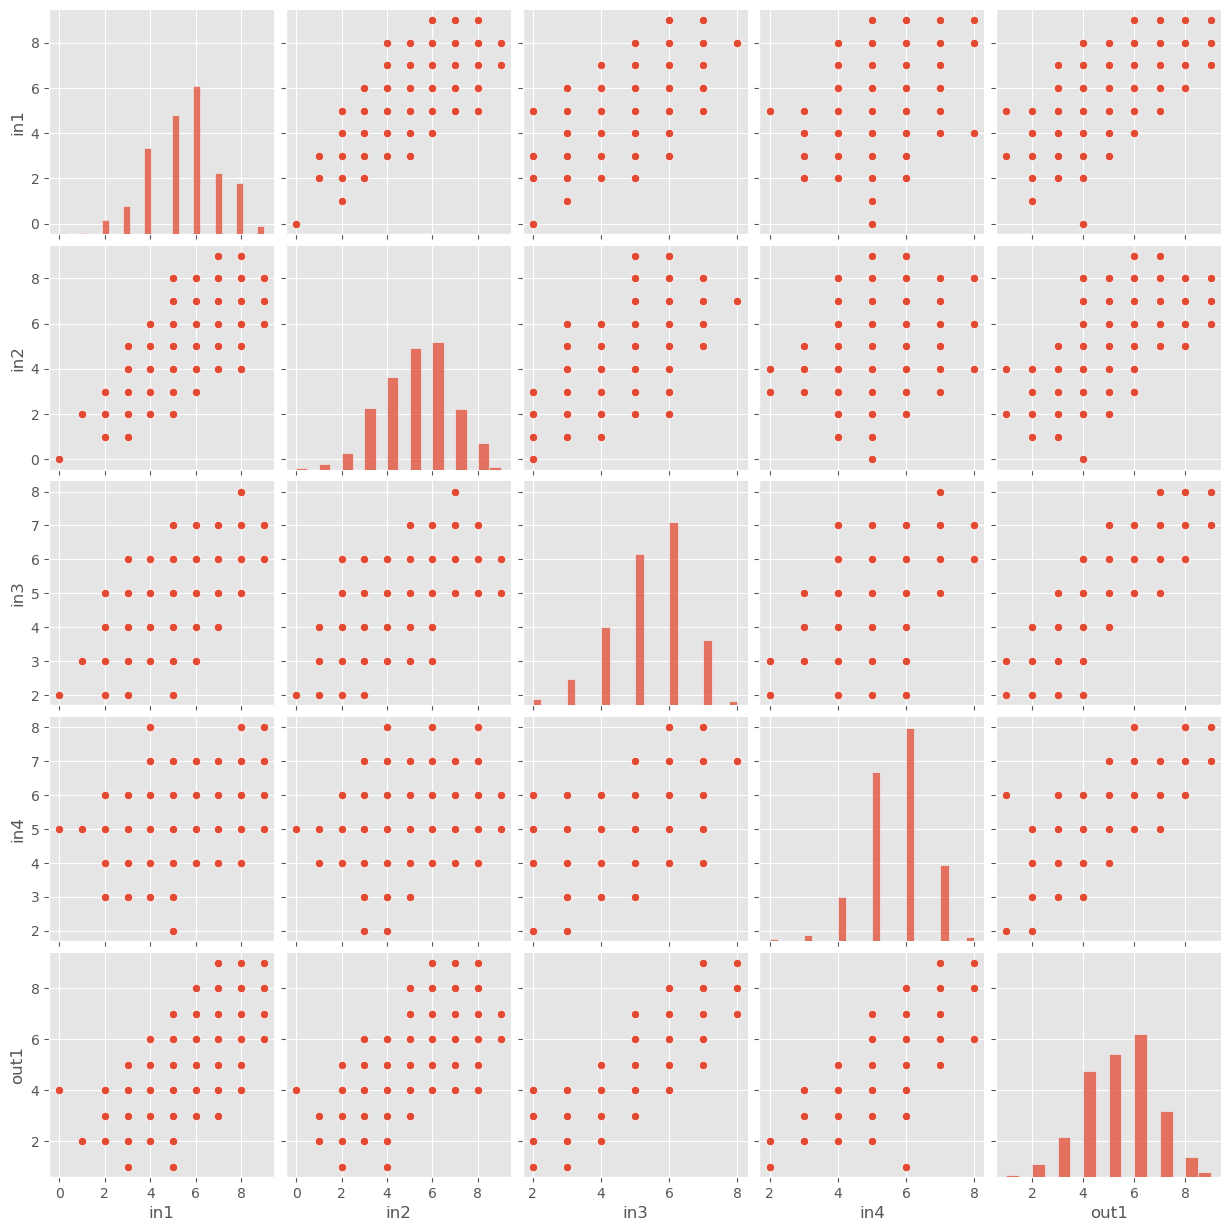

In [75]:
## Set warning to off
import warnings
warnings.filterwarnings("ignore")
sns.pairplot(df_data)

## TRAIN TEST SPLIT

In [76]:
df_data.head()

,in1,in2,in3,in4,out1
0,6.0,5.0,6.0,6.0,6.0
1,5.0,4.0,5.0,5.0,5.0
2,5.0,3.0,4.0,5.0,4.0
3,6.0,5.0,6.0,7.0,6.0
4,4.0,3.0,3.0,5.0,3.0


In [77]:
##### PARA UNA PRIMERA APROXIMACIÓN REDUCIDMOS DF_DATA A LAS DOS PRIMERAS COLUMNAS
df_data = df_data.iloc[:,:3]

## Check the number of unique rows
len(df_data.drop_duplicates())
## Drop duplicates of df_data -> Number of unique rows
#df_data = df_data.drop_duplicates()

103

In [78]:
from sklearn.preprocessing import MinMaxScaler
def normalize(tensor,min_val=None, max_val=None, mode='normalize'):
    if mode == 'normalize':
        if min_val is None:
            min_val = torch.min(tensor)
        if max_val is None:
            max_val = torch.max(tensor)
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
        return normalized_tensor,min_val,max_val
    elif mode == 'unnormalize':
        unnormalized_tensor = tensor * (max_val - min_val) + min_val
        return unnormalized_tensor
    else:
        raise ValueError("El modo debe ser 'normalize' o 'unnormalize'")

# Crear los escaladores
input_scaler = MinMaxScaler()

# Ajustar y transformar los datos de entrada
X = df_data.iloc[:,:3].values
#X = df_data[['displacement', 'horsepower']].values
X_tensor = torch.tensor(X, dtype=torch.float)

# Ajustar y transformar los datos de salida
y = df_data.iloc[:,-1].values.reshape(-1, 1)
#y = df_data[['mpg']].values
y_tensor = torch.tensor(y, dtype=torch.float)
y_tensor,min_val,max_vale = normalize(y_tensor,min_val=0,max_val=10,mode='normalize')

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.25, random_state=2023)

## Normalize the data using input_scaler
X_train_tensor = input_scaler.fit_transform(X_train_tensor)
X_test_tensor = input_scaler.transform(X_test_tensor)
## Convert to torch
X_train_tensor = torch.tensor(X_train_tensor, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.float)

# Guardar los datos
torch.save(X_train_tensor,'../Data/X_train_data.pt')
torch.save(X_test_tensor,'../Data/X_test_data.pt')
torch.save(y_train_tensor,'../Data/y_train_data.pt')
torch.save(y_test_tensor,'../Data/y_test_data.pt')

# Convertir los datos a un dataset para PyTorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor, y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt, batch_size=64) # create your dataloader

# Convertir los datos a un dataset para PyTorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor, y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt, batch_size=n_samples) # create your dataloader

## Print number of instances in train_data and test_data
print('Number of instances in train_data:', len(X_train_tensor))
print('Number of instances in test_data:', len(X_test_tensor))


Number of instances in train_data: 366
Number of instances in test_data: 122


# MODELLING

### MODEL TRAINING

{'data_load': {'x_lim': [0, 1], 'y_lim': [0, 1.0]}, 'model_architecture': {'actfunc': ['sigmoid'], 'batch_size': None, 'layers': [3, 5, 1]}, 'training': {'delta': 0.5, 'delta_external': 0.0, 'delta_synthetic': 0.0, 'epsilon_synthetic': 0.5, 'epsilon': 0.1, 'learning_rate': 0.1, 'monotone_relations': [1, 1], 'n_epochs': 500, 'patience': 100, 'plot_history': True, 'save_model': False, 'std_growth': 0.0, 'verbose': 1, 'weight_decay': 5e-05, 'seed': 0, 'optimizer_type': 'Adam'}}
------------------ Training ------------------
[  0/500] Train Loss 0.043152, Train Loss Mod 0.462774, Val Loss 0.015166
[  1/500] Train Loss 0.014405, Train Loss Mod 0.016505, Val Loss 0.010411
[  2/500] Train Loss 0.014659, Train Loss Mod 0.014659, Val Loss 0.011603
[  3/500] Train Loss 0.018140, Train Loss Mod 0.018140, Val Loss 0.014721
[  4/500] Train Loss 0.019938, Train Loss Mod 0.019938, Val Loss 0.014134
[  5/500] Train Loss 0.020052, Train Loss Mod 0.020052, Val Loss 0.014101
[  6/500] Train Loss 0.018635

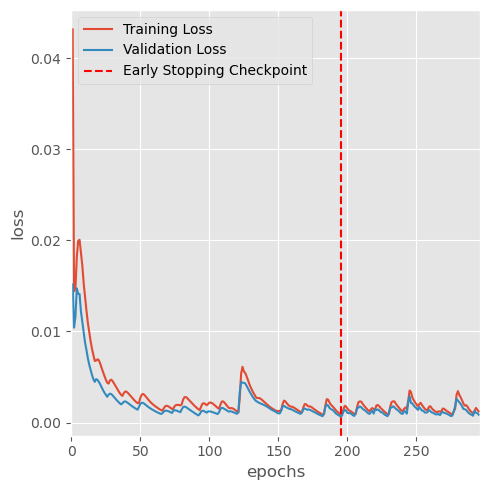

MSE Train: 0.00087, MSE Test: 0.00067
RMSE Train: 0.02957, RMSE Test: 0.02596
MAE Train: 0.02362, MAE Test: 0.0214


In [80]:
### CON PENALIZACION
torch.manual_seed(0)
with open('../Scripts/config_rw.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
print(config)
NN_Monotonic = train(config)
model = NN_Monotonic._model
Utils.print_errors(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,lipschitz_const=0.0,log=False,config=None)

In [81]:
## Compute accuracy rounding prediction values
y_pred = model(X_test_tensor)*10
y_pred = torch.round(y_pred).detach().numpy().flatten()
y_pred

array([5., 5., 6., 6., 5., 4., 5., 5., 7., 6., 6., 4., 7., 4., 6., 3., 6.,
       4., 4., 7., 6., 5., 5., 6., 5., 4., 8., 5., 5., 4., 7., 6., 6., 4.,
       6., 5., 7., 5., 6., 5., 6., 6., 3., 7., 6., 6., 4., 5., 5., 5., 3.,
       5., 5., 6., 6., 4., 6., 2., 7., 6., 5., 7., 5., 4., 5., 5., 5., 5.,
       5., 6., 5., 7., 6., 6., 7., 5., 5., 6., 5., 6., 5., 5., 4., 6., 6.,
       7., 6., 4., 4., 7., 6., 5., 6., 5., 6., 7., 6., 4., 6., 5., 4., 4.,
       5., 7., 5., 5., 6., 5., 8., 6., 5., 5., 5., 5., 4., 3., 7., 5., 7.,
       6., 6., 5.], dtype=float32)

In [82]:
y_test_tensor.flatten()*10

tensor([5., 5., 6., 6., 5., 4., 5., 5., 7., 6., 6., 4., 7., 4., 6., 3., 6., 4.,
        4., 7., 6., 5., 5., 6., 5., 4., 8., 5., 5., 4., 7., 6., 6., 4., 6., 5.,
        7., 5., 6., 5., 6., 6., 3., 7., 6., 6., 4., 5., 5., 5., 3., 5., 5., 6.,
        6., 4., 6., 2., 7., 6., 5., 7., 5., 5., 5., 5., 5., 5., 6., 6., 6., 7.,
        6., 6., 7., 5., 5., 6., 5., 6., 5., 5., 4., 6., 6., 7., 6., 5., 4., 7.,
        6., 5., 6., 5., 6., 7., 6., 4., 6., 5., 4., 4., 6., 7., 5., 4., 6., 5.,
        8., 6., 5., 5., 6., 5., 4., 3., 7., 5., 7., 6., 6., 5.])

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         1
         3.0       1.00      1.00      1.00         4
         4.0       0.89      0.94      0.91        17
         5.0       0.89      0.95      0.92        41
         6.0       1.00      0.90      0.95        41
         7.0       1.00      1.00      1.00        16
         8.0       1.00      1.00      1.00         2

    accuracy                           0.94       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.95      0.94      0.94       122



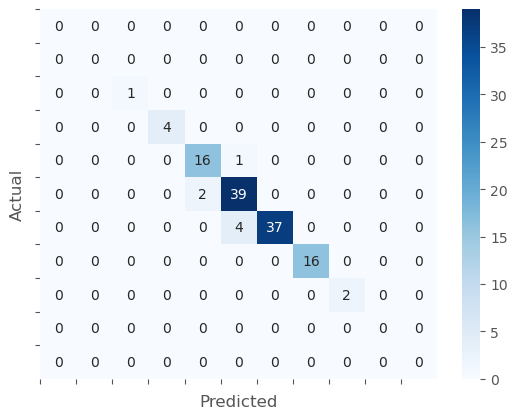

In [83]:
## Compute confusion matrix and plot as a heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(y_test_tensor.flatten()*10, y_pred, labels=range(11))

# Plot confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

## Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.flatten()*10, y_pred))

# Set x and y axis labels
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set class labels as tick labels
tick_labels = range(11)
plt.xticks(tick_labels)
plt.yticks(tick_labels)

# Show the plot
plt.show()



In [1]:
X_tensor = torch.cat((X_train_tensor,X_test_tensor),0)
y_tensor = torch.cat((y_train_tensor,y_test_tensor),0)
NN_Monotonic._plot_surface_interactive(X_tensor,y_tensor,0,1)

NameError: name 'torch' is not defined

In [ ]:
NN_Monotonic._plot_jacobian_interactive(X_tensor,0,1,0)

In [ ]:
NN_Monotonic._plot_jacobian_interactive(X_tensor,0,1,1)

### VORONOI COMPROBATION

In [87]:
## Extract weights and biases from the model
parameters = dict(model.state_dict())
weights = []
biases = []
for key, value in parameters.items():
    if 'weight' in key:
        weights.append(value.T)
    elif 'bias' in key:
        biases.append(value)
print('biases', biases)
print('weights', weights)
## Take one input and output random (it does not matter since the objetive is to bound the hessian for all input)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases, config['model_architecture']['actfunc'], x, y,sens_end_layer=len(config['model_architecture']['actfunc']))
global_lipschitz_constant=utilities_voronoi.hessian_bound(W=W,actfunc=config['model_architecture']['actfunc'],partial_monotonic_variable=[0,1,2],n_variables=3)
print('La constante de Lipschitz es: ',global_lipschitz_constant)

biases [tensor([ 1.5485,  0.5124,  0.6901, -0.2146,  0.2066]), tensor([0.7546])]
weights [tensor([[-0.4344,  0.4420,  0.1098, -0.0115, -0.1706],
        [-0.4535, -0.0372,  0.1998, -0.2819, -0.1508],
        [-0.9203,  1.2008,  0.7066, -1.1820, -1.2171]]), tensor([[-0.7870],
        [ 0.3373],
        [ 0.2513],
        [-0.3779],
        [-0.2987]])]
La constante de Lipschitz es:  1.494520497919829


In [ ]:
##### PLOT VORONOI WITH FURTHEST POINTS ##### -> 2 Dimensiones
torch.manual_seed(1)
np.random.seed(1)
## Escogemos n puntos al azar de X_train_tensor
n_points = 20
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
## Filter duplicated values
original_points = np.unique(original_points,axis=0)
inputs = torch.tensor(original_points,dtype=torch.float)


## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 0.0001
x_lim = [0,1]
y_lim = [0,1]
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
intervals_extended = [(x_lim[0]-epsilon, x_lim[1]+epsilon), (y_lim[0]-epsilon, y_lim[1]+epsilon)]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])


## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points,_ = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs=inputs,model=model,
                                                                                  global_lipschitz_constant=global_lipschitz_constant,
                                                                                  monotone_relation=1,variable_index=[0,1],n_variables=2)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(finite_vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

## Check if the space is filled
space_filled,distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print('El espacio está relleno: {}'.format(space_filled))

In [ ]:
## Add points to the Voronoi diagram
importlib.reload(utilities_voronoi)
#utilities_voronoi.add_points_to_voronoi(original_vor,original_points,finite_vor,dict_radios,vertices,distances,model,global_lipschitz_constant,x_lim,y_lim,monotone_relations=1,variable_index=[0,1],n_variables=2,plot_voronoi=False,epsilon=1e-5,max_iterations=10000)
utilities_voronoi.add_points_to_voronoi(original_vor=original_vor,original_points=original_points,finite_vor=finite_vor,dict_radios=dict_radios,
                                        vertices=vertices,distances=distances,model=model,global_lipschitz_constant=global_lipschitz_constant,
                                        actfunc=config['model_architecture']['actfunc'],intervals=intervals,monotone_relations=1,variable_index=[0,1],
                                        n_variables=2,plot_voronoi=False,epsilon=1e-5,max_iterations=1000)

In [89]:
#### PLOT VORONOI WITH FURTHEST POINTS ##### -> 3 Dimensiones
################ 3 DIMENSIONES
torch.manual_seed(1)
np.random.seed(1)
## Escogemos n puntos al azar de X_train_tensor
n_points = 5
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
## Filter duplicated values
original_points = np.unique(original_points,axis=0)
inputs = torch.tensor(original_points,dtype=torch.float)


## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 0.0001
x_lim = [0,1]
y_lim = [0,1]
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1]),(x_lim[0], x_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
intervals_extended = [(x - epsilon, y + epsilon) for x, y in intervals] 
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])


## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points,_ = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs=inputs,model=model,
                                                                                  global_lipschitz_constant=global_lipschitz_constant,
                                                                                  monotone_relation=1,variable_index=[0,1],n_variables=2)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_3D(finite_vor,all_points,original_points,radius_tot,vertices,plot_symmetric_points=False)

## Check if the space is filled
space_filled,distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print(space_filled)


Tiempo de ejecución: 0.0017991065979003906


False
